In [1]:
import numpy as np
import xray
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (4096*2 ,4096*2))
resource.getrlimit(resource.RLIMIT_NOFILE)


(8192, 8192)

In [50]:
import xgcm
import jmd95
from pygamman import gamman

In [4]:
iters = range(480, 210240, 480)
#iters = range(48,120720+1,96)
ddir = '/data/scratch/rpa/SOSE/run_np240'
ds = xray.decode_cf(xgcm.open_mdsdataset(ddir, iters, prefix=['SOstt_5d'], #prefix=['TSUVWP_1d',],
                             deltaT=900, ref_date='2005-01-01 00:00:00', calendar='gregorian'))
gcm = xgcm.GCMDataset(ds)

/home/rpa/xgcm/xgcm/mdsxray.py:243: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/rpa/xgcm/xgcm/mdsxray.py:243: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [5]:
xgcm.regrid_vertical?

In [18]:
# select a particular lat
jlev = 287
dslev = ds.isel(Y=jlev, Yp1=jlev)
dslev

<xray.Dataset>
Dimensions:  (X: 2160, Xp1: 2160, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 437)
Coordinates:
  * Xp1      (Xp1) float32 5.55112e-17 0.166667 0.333333 0.5 0.666667 ...
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 ...
    Yp1      float32 -30.125
  * Zp1      (Zp1) float32 0.0 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 ...
    Y        float32 -30.0416
  * X        (X) float32 0.0833333 0.25 0.416667 0.583333 0.75 0.916667 ...
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 -85.0 -104.0 ...
  * Zu       (Zu) float32 -10.0 -21.0 -33.0 -46.0 -60.0 -76.0 -94.0 -114.0 ...
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 2005-01-16 ...
Data variables:
    YC       (X) float32 -30.0416 -30.0416 -30.0416 -30.0416 -30.0416 ...
    YG       (Xp1) float32 -30.125 -30.125 -30.125 -30.125 -30.125 -30.125 ...
    rA       (X) float32 2.97221e+08 2.97221e+08 2.97221e+08 2.97221e+08 ...
    PHrefC   (Z) float32 49.05 152.055 264.87 387.495 519.9

In [104]:
sig0_levs = np.load('../data/rholevs.npy')
Nrho = len(sig0_levs)
v_sig0 = np.zeros(Nrho+1, dtype='f8')

In [105]:
sig2_levs = np.linspace(1030,1037.7,350)
Nrho2 = len(sig2_levs)
v_sig2 = np.zeros(Nrho2+1, dtype='f8')

In [106]:
gam_levs = np.linspace(22,28.5,360)
Ngam = len(gam_levs)
v_gam = np.zeros(Ngam+1, dtype='f8')

In [107]:
def calc_gam(dslev, n):
    Nz = dslev.dims['Z']
    Nx = dslev.dims['X']
    gam = np.zeros((Nz,Nx), 'f8')
    for i in xrange(Nx):
        gam[:,i], _, _ = gamman.gamma_n(
                         dslev.SALT[n,...,i].values.ravel(),
                         dslev.THETA[n,...,i].values.ravel(),
                         -dslev.Z.values.ravel(),
                         Nz,
                         dslev.XC[i].values,
                         dslev.YC[i].values)
    return np.ma.masked_array(gam, dslev.HFacC.values==0)

In [108]:
for n in tqdm(xrange(dslev.dims['time'])):
    salt = dslev.SALT[n]
    theta = dslev.THETA[n]
    sig0, _, _ = jmd95.eos.state_surface(theta.values, salt.values)
    sig2, _, _ = jmd95.eos.state(2000, theta.values, salt.values)
    gam = calc_gam(dslev, n)
    bins0 = np.digitize(sig0.ravel(), sig0_levs)
    bins2 = np.digitize(sig2.ravel(), sig2_levs)
    binsg = np.digitize(gam.ravel(), gam_levs)
    v_trans = dslev.VVEL[n] * dslev.drF * dslev.HFacS * dslev.dyC
    v_sig0 += np.bincount(bins0, weights=v_trans.values.ravel(), minlength=Nrho+1)
    v_sig2 += np.bincount(bins2, weights=v_trans.values.ravel(), minlength=Nrho2+1)
    v_gam += np.bincount(binsg, weights=v_trans.values.ravel(), minlength=Ngam+1)    
v_sig0 /= dslev.dims['time']
v_sig2 /= dslev.dims['time']
v_gam /= dslev.dims['time']


In [109]:
psi0 = np.cumsum(v_sig0)
psi2 = np.cumsum(v_sig2)
psig = np.cumsum(v_gam)

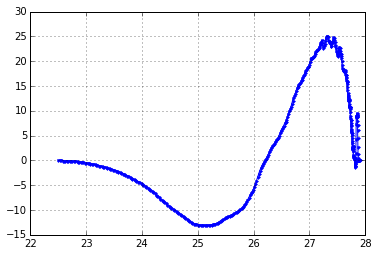

In [110]:
plt.plot(sig0_levs-1000, psi0[1:]/1e6, '.-')
#plt.xlim(26,28)
plt.grid()

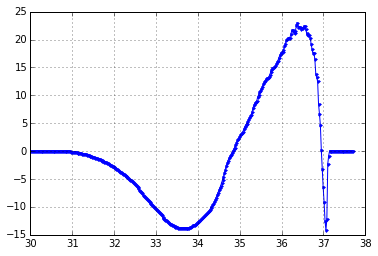

In [111]:
plt.plot(sig2_levs-1000, psi2[1:]/1e6, '.-')
#plt.xlim(26,28)
plt.grid()

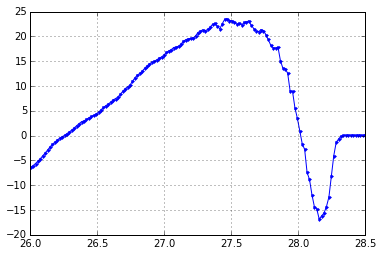

In [114]:
plt.plot(gam_levs, psig[1:]/1e6, '.-')
plt.xlim(26,28.5)
plt.grid()

In [117]:
# let's save these streamfunctions
import xray
ds = xray.Dataset({
        'psi_sigma0': ('sigma0', psi0[1:]),
        'psi_sigma2': ('sigma2', psi2[1:]),
        'psi_gamman': ('gamman', psig[1:]),
        'sigma0': ('sigma0', sig0_levs-1000),
        'sigma2': ('sigma2', sig2_levs-1000),
        'gamman': ('gamman', gam_levs)
    })
ds.to_netcdf('../data/SOSE_streamfuctions_30S.nc')
ds

<xray.Dataset>
Dimensions:     (gamman: 360, sigma0: 400, sigma2: 350)
Coordinates:
  * gamman      (gamman) float64 22.0 22.02 22.04 22.05 22.07 22.09 22.11 ...
  * sigma0      (sigma0) float64 22.5 22.53 22.55 22.58 22.6 22.63 22.65 ...
  * sigma2      (sigma2) float64 30.0 30.02 30.04 30.07 30.09 30.11 30.13 ...
Data variables:
    psi_sigma2  (sigma2) float64 0.06658 0.09462 0.09462 0.09763 0.06565 ...
    psi_sigma0  (sigma0) float64 -9.623e+03 -1.233e+04 -1.603e+04 -2.037e+04 ...
    psi_gamman  (gamman) float64 -0.02468 -0.02468 -0.02998 -0.02998 ...

<matplotlib.colorbar.Colorbar instance at 0x7ecfe4ceba28>

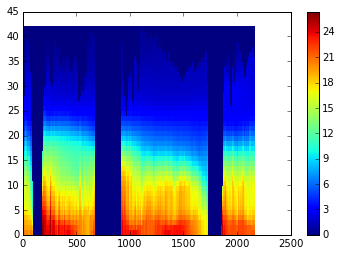

In [96]:
plt.pcolormesh(theta.values)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7ecfe47ab248>

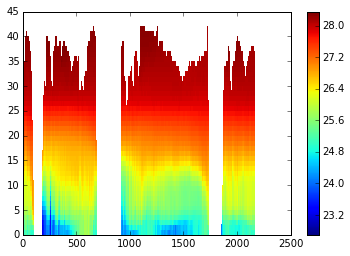

In [99]:
gam = calc_gam(dslev, n)
plt.pcolormesh(gam)
plt.colorbar()

(26.5, 28)

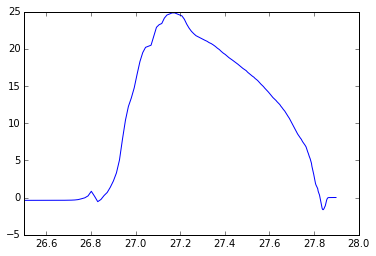

In [24]:
plt.plot(rholevs-1000, transformation[1:]/1e6)
plt.xlim(26.5,28)

In [13]:
from pygamman import gamman

In [16]:
t, s, lon, lat = xray.broadcast_arrays(dslev.THETA[n], dslev.SALT[n], dslev.XC, dslev.YC)
#gamman = gamman.gamma_n()

In [17]:
N = len(s.ravel())
gn, _, _ = gamman.gamma_n(s.ravel(), t.ravel(), 700, lon, lat)

TypeError: Required argument 'alat' (pos 6) not found

In [25]:
vol = ds.HFacC * ds.rA * ds.drF

In [40]:
n = 0

def get_volume_dist(n):
    sig0, _, _ = jmd95.eos.state_surface(ds.THETA[n].values.ravel(), ds.SALT[n].values.ravel())
    sig0.shape = ds.THETA[n].shape
    bins = np.digitize(sig0[:klev].ravel(), rholevs)
    vol_sig0 = np.bincount(bins, weights=vol[:klev].values.ravel(), minlength=Nrho+1)
    return vol_sig0

In [43]:
Nt = len(ds.time)
vol_init = get_volume_dist(0)
vol_fin = get_volume_dist(Nt-1)

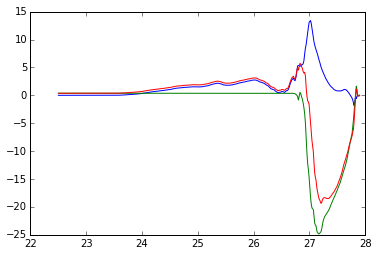

In [53]:
vol_diff = (vol_fin - vol_init)
DT = Nt * 5* (24*60*60.)
rearrangement = np.cumsum(vol_diff) / DT
plt.plot(rholevs-1000, -rearrangement[1:] / 1e6)
plt.plot(rholevs-1000, -transformation[1:] / 1e6)
plt.plot(rholevs-1000, (-rearrangement[1:] -transformation[1:] ) / 1e6)


In [54]:
# this is not really a proper volume budget... what about the open boundary!

In [53]:
dslev.XC.shape

(2160,)

In [70]:
gam = np.ma.masked_array(gam, dslev.HFacC.values==0)
gam.max()

28.354425430297852

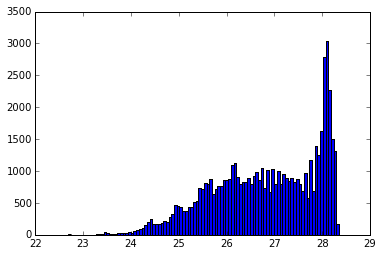

In [74]:
plt.hist(gam.compressed(), bins=100);

In [79]:

import time

In [81]:
for n in tqdm(xrange(100)):
    time.sleep(0.1)